# NLU project : Invoice Information Extraction using /Llama-3.2-3B-Instruct

##  Project Overview

This notebook explores **Invoice Information Extraction** using the **/Llama-3.2-3B-Instruct** on the **invoices text based dataset**. The aim is to extract structured key-value fields (e.g., invoice number , Prices , date , subtotal, taxes, and total amounts) from text and analyze model performance both **before and after fine-tuning** using **LoRA (Low-Rank Adaptation)**.



In [ ]:
# Core libraries
!pip install -U pillow

# Hugging Face Transformers + Accelerate (from GitHub for latest SFTTrainer)
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate

# Datasets for loading CSV and splitting
!pip install datasets

# 4-bit quantization support via bitsandbytes
!pip install bitsandbytes

# PEFT for LoRA
!pip install peft

# TRL for SFTTrainer (latest LoRA fine-tuning trainer)
!pip install trl

# Evaluation and plotting
!pip install scikit-learn matplotlib

# Hugging Face Hub access (login and model push)
!pip install huggingface_hub


### Let's import some Libraries



In [4]:
import os
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from trl import SFTTrainer
from huggingface_hub import login


### Load the dataset and perpare it for finetunning

In [6]:
# read the dataset
invoice_df = pd.read_csv('/content/sample_data/invoice_dataset.csv')
#let's see the first 5 rows
invoice_df.head()


,text,json
0,Invoice No: INV-61I4-21697\nDate: 18-11-2024\n...,"{""invoice_number"": ""INV-6114-21697"", ""invoice_..."
1,Invoice No: INV-1440-23854\nDate: 06-07-2024\n...,"{""invoice_number"": ""INV-1440-23854"", ""invoice_..."
2,Invoice No: INV-0115-92689\nDate: 08-1Z-2024\n...,"{""invoice_number"": ""INV-0115-92689"", ""invoice_..."
3,Invoice No: INV-234S-7883I\nDate: 28 May 2024\...,"{""invoice_number"": ""INV-2345-78831"", ""invoice_..."
4,Invoice No: INV-8220-767I8\nDate: 06/06/2024\n...,"{""invoice_number"": ""INV-8220-76718"", ""invoice_..."


In [5]:
# Let's see two Samples from the data
for index, row in invoice_df.head(2).iterrows():
    print("Text:", row["text"],"/n")  # Plain (unstructure) invoice text
    print("GT:", row["json"],"/n")   # Ground-truth structured fields

Text: Invoice No: INV-61I4-21697
Date: 18-11-2024
Due Date: Dec 04, 2024

Seller:
Cherry-Smith
Address: 7390 Emily Plaza, Collinsport, IA 50590
VAT ID: ic56327898

Buyer:
Graham-Miles
Address: USCGC Davis, FPO AA 21755

Description          Qty   Unit Price
Implement Cross Media Schemas    5      ¥  331.44
Matrix Interactive Portals   10      ¥   93.54

Subtotal: ¥2592.60
Tax (5%): ¥129.63
Total Due: ¥2722.23

Payment Terms: Due on receipt /n
GT: {"invoice_number": "INV-6114-21697", "invoice_date": "2024-11-18", "due_date": "2024-12-04", "seller": {"name": "Cherry-Smith", "address": "7390 Emily Plaza, Collinsport, IA 50590", "vat_id": "ic56327898"}, "buyer": {"name": "Graham-Miles", "address": "USCGC Davis, FPO AA 21755"}, "line_items": [{"description": "Implement Cross-Media Schemas", "quantity": 5, "unit_price": 331.44}, {"description": "Matrix Interactive Portals", "quantity": 10, "unit_price": 93.54}], "subtotal": 2592.6000000000004, "tax": 129.63, "total": 2722.23, "currency": "JP

## Dataset Formating and preprocessing

In [3]:
# split the data to train (90%)and test(10%)
train_dataset = Dataset.from_pandas(invoice_df.iloc[:900].reset_index(drop=True))
test_dataset = Dataset.from_pandas(invoice_df.iloc[900:].reset_index(drop=True))


In [7]:
# Prompt formatting
def create_prompt(text):
    return f"""<|start_header_id|>system<|end_header_id|>
You are an intelligent invoice parser. Given a raw invoice text, extract structured information in JSON format.

<|start_header_id|>user<|end_header_id|>
{text}
Your task is to extract:
- invoice_number
- invoice_date
- due_date
- seller (name, address, vat_id)
- buyer (name, address)
- line_items (description, quantity, unit_price)
- subtotal
- tax
- total
- currency
- payment_terms

Return only valid JSON.<|end_header_id|>"""

# Format prompt-completion pair
def format_instruction(example):
    return {
        "prompt": create_prompt(example["text"]),
        "completion": example["json"]
    }

train_dataset = train_dataset.map(format_instruction)
test_dataset = test_dataset.map(format_instruction)

# Tokenize inputs for training
def preprocess_for_training(example):
    # Merge prompt and completion for decoder-style LM
    full_text = example["prompt"] + "\n" + example["completion"]

    # Tokenize entire input-output
    tokenized = tokenizer(
        full_text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Set labels = input_ids (causal LM learns to predict next token)
    tokenized["labels"] = tokenized["input_ids"].clone()
    return {k: v[0] for k, v in tokenized.items()}  # remove batch dim

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_for_training)
test_dataset = test_dataset.map(preprocess_for_training)


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [8]:
train_dataset[0].keys()
# Output: dict_keys(['input_ids', 'attention_mask', 'labels'])

dict_keys(['text', 'json', 'prompt', 'completion', 'input_ids', 'attention_mask', 'labels'])

## Load the model and Tokenizer from Hugging face

In [5]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `nlu` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when

In [6]:
# Load Tokenizer & Model with 4-bit Quantization ---
model_id = "meta-llama/Llama-3.2-3B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
#add padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [9]:
# Prepare the model for LoRA and adding Adapter weights
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

## Defining Training Arguements and start training

In [10]:
import logging
from transformers import TrainingArguments, DataCollatorForLanguageModeling, TrainerCallback

# Setup logging
logging.basicConfig(level=logging.INFO)

# Data collator for causal LM
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Custom callback to print loss at each logging step
class PrintLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            print(f"Step {state.global_step}: loss = {logs['loss']:.4f}")

# Training arguments
training_args = TrainingArguments(
    output_dir="llama3-lora-invoice",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    max_steps=100,
    learning_rate=2e-4,
    logging_steps=1,
    logging_strategy="steps",
    save_strategy="epoch",
    #evaluation_strategy="epoch",
    label_names=["labels"],  # <-- This must match what my dataset returns
    bf16=True,
    report_to="none",
    save_total_limit=2,
    disable_tqdm=False,
    log_level="info"
)

# Setup trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    #eval_dataset=test_dataset,
    data_collator=data_collator,
    callbacks=[PrintLossCallback()],
)

# Start training
trainer.train()

Truncating train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text, json, completion, labels, prompt. If text, json, completion, labels, prompt are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 900
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 100
  Number of trainable parameters = 18,350,080
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an except

Step,Training Loss
1,2.250800
2,2.154200
3,2.065300
4,2.079000
5,1.951800
6,1.932500
7,1.901300
8,1.850700
9,1.836900
10,1.763100


Step 1: loss = 2.2508
Step 2: loss = 2.1542
Step 3: loss = 2.0653
Step 4: loss = 2.0790
Step 5: loss = 1.9518
Step 6: loss = 1.9325
Step 7: loss = 1.9013
Step 8: loss = 1.8507
Step 9: loss = 1.8369
Step 10: loss = 1.7631
Step 11: loss = 1.7307
Step 12: loss = 1.7008
Step 13: loss = 1.6547
Step 14: loss = 1.6244
Step 15: loss = 1.5526
Step 16: loss = 1.5201
Step 17: loss = 1.4842
Step 18: loss = 1.4595
Step 19: loss = 1.4512
Step 20: loss = 1.3813
Step 21: loss = 1.3599
Step 22: loss = 1.2856
Step 23: loss = 1.2885
Step 24: loss = 1.2446
Step 25: loss = 1.2854
Step 26: loss = 1.1535
Step 27: loss = 1.2201
Step 28: loss = 1.0914
Step 29: loss = 1.1071
Step 30: loss = 1.0180
Step 31: loss = 1.0337
Step 32: loss = 0.9899
Step 33: loss = 1.0243
Step 34: loss = 0.9807
Step 35: loss = 0.9847
Step 36: loss = 0.9081
Step 37: loss = 0.9338
Step 38: loss = 0.9709
Step 39: loss = 0.9563
Step 40: loss = 0.9707
Step 41: loss = 0.9266
Step 42: loss = 0.9167
Step 43: loss = 0.8739
Step 44: loss = 0.87

Saving model checkpoint to llama3-lora-invoice/checkpoint-100


Step 100: loss = 0.7499


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16

TrainOutput(global_step=100, training_loss=1.0666333049535752, metrics={'train_runtime': 4075.4629, 'train_samples_per_second': 0.196, 'train_steps_per_second': 0.025, 'total_flos': 6972450747187200.0, 'train_loss': 1.0666333049535752})

### Mearge and save the model after training

In [11]:
#  Merge and Save
merged_model = model.merge_and_unload()
merged_model.save_pretrained("llama3-lora-invoice-final")
tokenizer.save_pretrained("llama3-lora-invoice-final")


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
Configuration saved in llama3-lora-invoice-final/config.json
Configuration saved in llama3-lora-invoice-final/generation_config.json
Model weights saved in llama3-lora-invoice-final/model.safetensors
tokenizer config file saved in llama3-lora-invoice-final/tokenizer_config.json
Special tokens file saved in llama3-lora-invoice-final/special_tokens_map.json


('llama3-lora-invoice-final/tokenizer_config.json',
 'llama3-lora-invoice-final/special_tokens_map.json',
 'llama3-lora-invoice-final/tokenizer.json')

## Push the Model and Tokenizer on my Repo at Hugging Face

In [13]:
#  Push to Hugging Face Hub
# login(token="YOUR_HF_TOKEN")
merged_model.push_to_hub("khalifa1/llama3-invoice-extraction")
tokenizer.push_to_hub("khalifa1/llama3-invoice-extraction")

Configuration saved in /tmp/tmpt7xdr3ib/config.json
Configuration saved in /tmp/tmpt7xdr3ib/generation_config.json
Model weights saved in /tmp/tmpt7xdr3ib/model.safetensors
Uploading the following files to khalifa1/llama3-invoice-extraction: config.json,generation_config.json,model.safetensors,README.md


model.safetensors:   0%|          | 0.00/3.03G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer config file saved in /tmp/tmp2m7c44yl/tokenizer_config.json
Special tokens file saved in /tmp/tmp2m7c44yl/special_tokens_map.json
Uploading the following files to khalifa1/llama3-invoice-extraction: special_tokens_map.json,tokenizer.json,tokenizer_config.json,README.md


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/khalifa1/llama3-invoice-extraction/commit/f60c65dafef29be51d516604deeb96439d9522d5', commit_message='Upload tokenizer', commit_description='', oid='f60c65dafef29be51d516604deeb96439d9522d5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/khalifa1/llama3-invoice-extraction', endpoint='https://huggingface.co', repo_type='model', repo_id='khalifa1/llama3-invoice-extraction'), pr_revision=None, pr_num=None)

## Now Let's load the finetuned model from hub to Evaluate it

In [5]:
# Load Tokenizer & Model with 4-bit Quantization ---
model_id = "khalifa1/llama3-invoice-extraction"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
#add padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:212: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/3.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

## Implementation of Inference Pipeline

> First, let's define our prompt template for invoice information extraction:

In [7]:
def create_prompt(text):
    return f"""<|start_header_id|>system<|end_header_id|>
You are an intelligent invoice parser. Given a raw invoice text, extract structured information in JSON format.

<|start_header_id|>user<|end_header_id|>
{text}
Your task is to extract:
- invoice_number
- invoice_date
- due_date
- seller (name, address, vat_id)
- buyer (name, address)
- line_items (description, quantity, unit_price)
- subtotal
- tax
- total
- currency
- payment_terms

Return only valid JSON.<|end_header_id|>"""

### Inference Function
> Now, let's define a function to generate predictions from the model:

In [9]:
def infer(prompt, model, tokenizer, max_new_tokens=512):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
      output_ids = model.generate(
          **inputs,
          max_new_tokens=max_new_tokens,
          do_sample=False,
          num_beams=1,
          pad_token_id=tokenizer.eos_token_id
      )

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text

### Post-Processing Functions
> We need functions to extract and process the JSON output:

In [16]:
import re
import json
def postprocess(text):
    try:
        # Extract JSON block between ```json and ```
        match = re.search(r"```json\s*(\{.*?\})\s*```", text, re.DOTALL)
        if match:
            json_str = match.group(1)
        else:
            # Fallback: try to find the first valid-looking JSON object
            match = re.search(r"(\{.*\})", text, re.DOTALL)
            if not match:
                raise ValueError(f"No JSON object found in the text:\n{text}")
            json_str = match.group(1)

        parsed_text = json.loads(json_str)
        return parsed_text
    except Exception as e:
        raise ValueError(f"Unable to parse prediction text - {text}\n\nError: {e}")

def flatten_dict(d, parent_key=""):
    """Flatten nested dictionaries for easier comparison"""
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}.{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key))
        elif isinstance(v, list):
            if all(isinstance(i, dict) for i in v):
                for idx, item in enumerate(v):
                    items.update(flatten_dict(item, f"{new_key}[{idx}]"))
            else:
                items[new_key] = v
        else:
            items[new_key] = v
    return items

### fine tuneed Model Evaluation
> Let's evaluate the model on our test set (the last 100 invoices):

In [ ]:
# Prepare lists to store predictions and ground truths
from tqdm import tqdm
import json
prediction_list = []
ground_truth_list = []

# Define test set (last 100 samples)
test_data = invoice_df.iloc[-100:]

# Inference Loop
for i, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Running inference"):
    invoice_text = row["text"]
    ground_truth = json.loads(row["json"])
    ground_truth_list.append(ground_truth)

    prompt_text = create_prompt(invoice_text)
    prediction = infer(prompt=prompt_text, model=model, tokenizer=tokenizer)
    prediction_list.append(prediction)



In [20]:
# Clear GPU memory
#torch.cuda.empty_cache()

# Post-process predictions
cleaned_predictions = []
for pred in tqdm(prediction_list, desc="Post-processing predictions"):
    try:
        cleaned_pred = postprocess(pred)
        cleaned_predictions.append(cleaned_pred)
    except Exception as e:
        print(f"Error processing prediction: {e}")
        # Insert empty dict as placeholder for failed predictions
        cleaned_predictions.append({})

# Print a sample prediction (structure Output)
print("Sample prediction:")
print(json.dumps(cleaned_predictions[0], indent=2, ensure_ascii=False))

Post-processing predictions: 100%|██████████| 100/100 [00:00<00:00, 18103.09it/s]

Sample prediction:
{
  "invoice_number": "INV-5327-65O84",
  "invoice_date": "16 November 2024",
  "due_date": "30-11-2024",
  "seller": {
    "name": "Peters LLC",
    "address": "95482 Anderson Trace Apt. 785, West Scott, TX 85061",
    "vat_id": "Lv56287235"
  },
  "buyer": {
    "name": "Bush-Perez",
    "address": "651 Henry Ranch, West Rachelshire, NJ 21477"
  },
  "line_items": [
    {
      "description": "Syndicate User-Centric Systems",
      "quantity": 5,
      "unit_price": "¥ 401.03"
    },
    {
      "description": "Synthesize E-Business Partnerships",
      "quantity": 5,
      "unit_price": "¥ 892.21"
    },
    {
      "description": "Morph Cross-Platform Deliverables",
      "quantity": 8,
      "unit_price": "¥   46.50"
    },
    {
      "description": "Embrace 24/7 Infrastructures",
      "quantity": 3,
      "unit_price": "¥ 612.69"
    },
    {
      "description": "Scale Visionary Applications",
      "quantity": 8,
      "unit_price": "¥ 500.26"
    }
  ],
  

### Calculating Evaluation Metrics
> Let's calculate accuracy and other metrics:

In [21]:
metrics_list = []

for i in range(len(cleaned_predictions)):
    metrics_dict = {}
    gt = ground_truth_list[i]
    pred = cleaned_predictions[i]

    # Normalize nested lists
    if isinstance(gt.get("line_items"), dict):
        gt["line_items"] = [gt["line_items"]]
    if isinstance(pred.get("line_items"), dict):
        pred["line_items"] = [pred["line_items"]]

    gt_flat = flatten_dict(gt)
    pred_flat = flatten_dict(pred)

    total_keys = len(gt_flat)
    matched_keys = 0

    for key, gt_value in gt_flat.items():
        pred_value = pred_flat.get(key, "")
        if gt_value == pred_value:
            matched_keys += 1

    metrics_dict["invoice_no"] = i
    metrics_dict["total_keys"] = total_keys
    metrics_dict["matched_keys"] = matched_keys
    metrics_dict["accuracy"] = (matched_keys / total_keys) * 100
    metrics_list.append(metrics_dict)

# Create DataFrame with metrics
metrics_df = pd.DataFrame(metrics_list)
metrics_df.round(2).head(10)

# Calculate overall accuracy
overall_accuracy = metrics_df["accuracy"].mean().round(2)
print(f"Overall finetune Model Accuracy: {overall_accuracy}%")

# Save metrics for later comparison
metrics_df.to_csv("finetune_model_metrics.csv", index=False)

Overall finetune Model Accuracy: 60.3%


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_list = []

for i in range(len(cleaned_predictions)):
    metrics_dict = {}
    gt = ground_truth_list[i]
    pred = cleaned_predictions[i]

    # Normalize nested lists
    if isinstance(gt.get("line_items"), dict):
        gt["line_items"] = [gt["line_items"]]
    if isinstance(pred.get("line_items"), dict):
        pred["line_items"] = [pred["line_items"]]

    gt_flat = flatten_dict(gt)
    pred_flat = flatten_dict(pred)

    total_keys = len(gt_flat)
    matched_keys = 0

    # Key-value level comparison
    gt_kv_set = set(gt_flat.items())
    pred_kv_set = set(pred_flat.items())

    tp = len(gt_kv_set & pred_kv_set)
    fp = len(pred_kv_set - gt_kv_set)
    fn = len(gt_kv_set - pred_kv_set)

    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    for key, gt_value in gt_flat.items():
        pred_value = pred_flat.get(key, "")
        if gt_value == pred_value:
            matched_keys += 1

    metrics_dict["invoice_no"] = i
    metrics_dict["total_keys"] = total_keys
    metrics_dict["matched_keys"] = matched_keys
    metrics_dict["accuracy"] = (matched_keys / total_keys) * 100
    metrics_dict["precision"] = precision
    metrics_dict["recall"] = recall
    metrics_dict["f1_score"] = f1

    metrics_list.append(metrics_dict)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Round and display top 10
metrics_df = metrics_df.round(4)
print(metrics_df.head(10))

# Calculate and print overall averages
overall_metrics = metrics_df[["accuracy", "precision", "recall", "f1_score"]].mean().round(4)
print("\nOverall Metrics:")
print(overall_metrics)

# Save results
metrics_df.to_csv("finetuned_model_metrics_with_f1.csv", index=False)

   invoice_no  total_keys  matched_keys  accuracy  precision  recall  f1_score
0           0          28            16   57.1429     0.5714  0.5714    0.5714
1           1          22            13   59.0909     0.5909  0.5909    0.5909
2           2          25            14   56.0000     0.5417  0.5200    0.5306
3           3          28            22   78.5714     0.7857  0.7857    0.7857
4           4          16            11   68.7500     0.6875  0.6875    0.6875
5           5          22            12   54.5455     0.5455  0.5455    0.5455
6           6          19            11   57.8947     0.5789  0.5789    0.5789
7           7          22            13   59.0909     0.5714  0.5455    0.5581
8           8          22            13   59.0909     0.5714  0.5455    0.5581
9           9          25            14   56.0000     0.5417  0.5200    0.5306

Overall Metrics:
accuracy     60.3038
precision     0.5985
recall        0.5921
f1_score      0.5952
dtype: float64


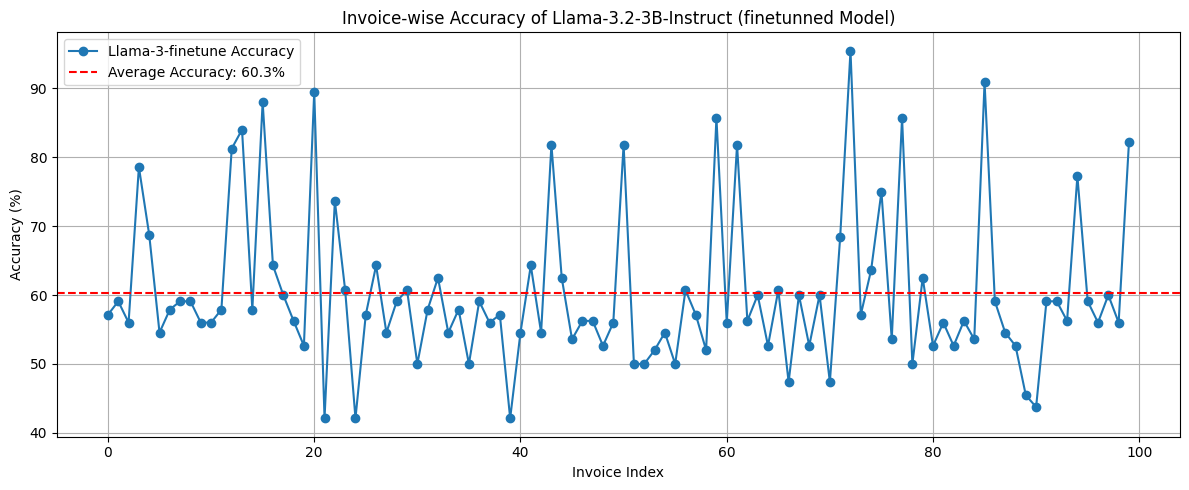

In [23]:
# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(metrics_list)), [m["accuracy"] for m in metrics_list], marker='o', label="Llama-3-finetune Accuracy")
plt.axhline(overall_accuracy, color='red', linestyle='--', label=f"Average Accuracy: {overall_accuracy}%")
plt.xlabel("Invoice Index")
plt.ylabel("Accuracy (%)")
plt.title("Invoice-wise Accuracy of Llama-3.2-3B-Instruct (finetunned Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("funetuned_model_accuracy.png")
plt.show()

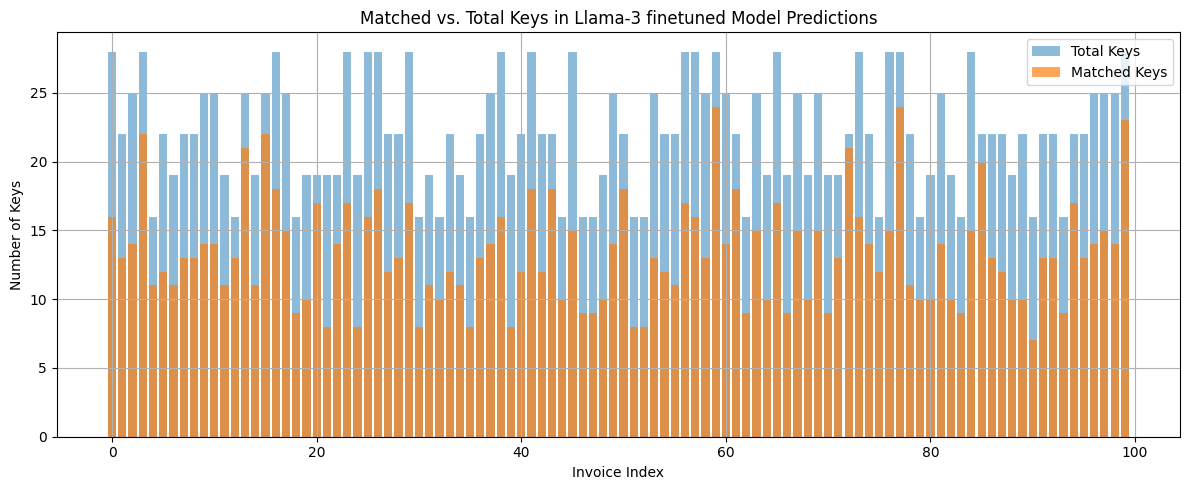

In [24]:
# Key match plot
matched_keys = [m["matched_keys"] for m in metrics_list]
total_keys = [m["total_keys"] for m in metrics_list]

plt.figure(figsize=(12, 5))
plt.bar(range(len(metrics_list)), total_keys, label="Total Keys", alpha=0.5)
plt.bar(range(len(metrics_list)), matched_keys, label="Matched Keys", alpha=0.7)
plt.xlabel("Invoice Index")
plt.ylabel("Number of Keys")
plt.title("Matched vs. Total Keys in Llama-3 finetuned Model Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("finetuned_model_key_matches.png")
plt.show()

## Comparative plot between base model and fine-tuned model

<ipython-input-3-47c730acd163>:37: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


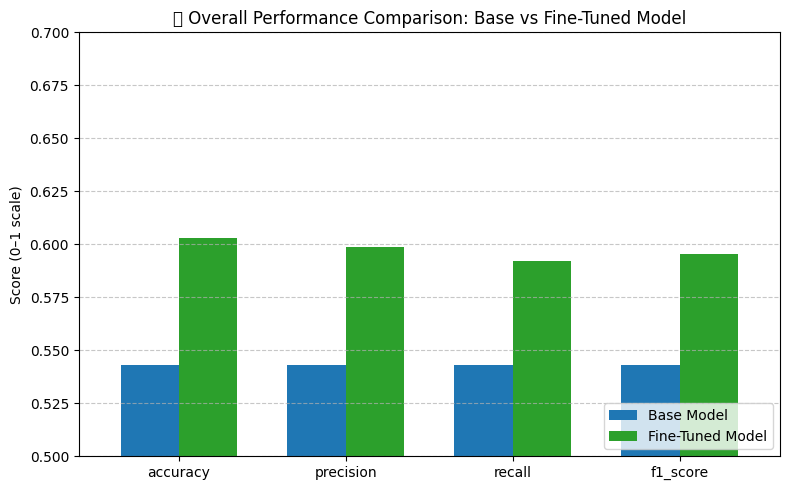

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

# Overall metrics for base and fine-tuned models
base_metrics = {
    "accuracy": 54.3194 / 100,
    "precision": 0.5432,
    "recall": 0.5432,
    "f1_score": 0.5432,
}

fine_tuned_metrics = {
    "accuracy": 60.3038 / 100,
    "precision": 0.5985,
    "recall": 0.5921,
    "f1_score": 0.5952,
}

# Create a DataFrame
df_metrics = pd.DataFrame({
    "Base Model": base_metrics,
    "Fine-Tuned Model": fine_tuned_metrics
})

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
df_metrics.plot(kind="bar", ax=ax, color=["#1f77b4", "#2ca02c"], width=0.7)
plt.title(" Overall Performance Comparison: Base vs Fine-Tuned Model")
plt.ylabel("Score (0–1 scale)")
plt.ylim(0.5, 0.7)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

